### DATA612 Project 1.
### Author: Farhod Ibragimov

## Movie Recommender
This notebook builds a simple **bias-based recommendation system** using movie ratings collected from my friends via a Google form. The main goal is to predict missing ratings by estimating global, user and item biases.

In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split





In [68]:
import sys
#!{sys.executable} -m pip show matplotlib


In [69]:
np.random.seed(123)

I will use movie ratings from the surveys completed by my friends:
- The timestamp column is removed as it's not relevant to the analysis.
- The Name column is set as the index for each user
- Ratings are converted to float format.

In [70]:
movie_rating_df = pd.read_csv("https://raw.githubusercontent.com/farhodibr/CUNY-SPS-MSDS/refs/heads/main/DATA612/PROJECT1/movie_reviews%20-%20Form%20Responses%201%20(1).csv")
movie_rating_df = movie_rating_df.drop(columns=["Timestamp"])
movie_rating_df = movie_rating_df.set_index("Name")
movie_rating_df["Gladiator2"] = movie_rating_df["Gladiator2"].astype(float)


In [71]:
print(movie_rating_df)

                      Gladiator2  Wolfs  The_Substance  Bad_Boys4  \
Name                                                                
Aiuna                        1.0    NaN            5.0        2.0   
Ilya                         3.0    3.0            3.0        3.0   
Vadim                        1.0    NaN            3.0        1.0   
Vladimir Storchevoy          5.0    5.0            5.0        5.0   
Timur                        5.0    5.0            4.0        5.0   
Gosha                        4.0    5.0            3.0        5.0   
Bob                          3.0    5.0            4.0        NaN   
Kirill                       4.0    4.0            NaN        5.0   
James                        3.0    4.0            4.0        5.0   

                      The_Beekeeper  Rebel_Ridge  
Name                                              
Aiuna                           2.0          1.0  
Ilya                            NaN          3.0  
Vadim                           3.0 

In [72]:
movie_rating_df.style\
    .set_caption("Movie ratings by users")\
    .format(precision=2, na_rep="NaN")
    


,Gladiator2,Wolfs,The_Substance,Bad_Boys4,The_Beekeeper,Rebel_Ridge
Name,,,,,,
Aiuna,1.00,NaN,5.00,2.00,2.00,1.00
Ilya,3.00,3.00,3.00,3.00,NaN,3.00
Vadim,1.00,NaN,3.00,1.00,3.00,3.00
Vladimir Storchevoy,5.00,5.00,5.00,5.00,4.00,4.00
Timur,5.00,5.00,4.00,5.00,3.00,3.00
Gosha,4.00,5.00,3.00,5.00,4.00,4.00
Bob,3.00,5.00,4.00,NaN,3.00,NaN
Kirill,4.00,4.00,NaN,5.00,3.00,3.00
James,3.00,4.00,4.00,5.00,3.00,3.00


As we see some of my friends didn't rate some movies. In this project I will work to predict ratings for unrated movies using simple bias-based recommendation system.

## Splitting data into train and test sets
I used a structured split instead of random sampling:
- Every other row and every other column are selected to create the test set
- It's simulates a controlled missing data pattern
- Remaining values are used for train set.

In [73]:
mask = ~movie_rating_df.isna()
test_mask = pd.DataFrame(False, index=mask.index, columns=mask.columns)

for i, user in enumerate(movie_rating_df.index):
    for j, item in enumerate(movie_rating_df.columns):
        if i % 2 == 0 and j % 2 == 1 and mask.at[user, item]:
            test_mask.at[user, item] = True

train_mask = mask & ~test_mask
train_df = movie_rating_df.where(train_mask)
test_df = movie_rating_df.where(test_mask)


In [74]:
train_df.style\
    .set_caption("Train set")\
    .format(precision=2, na_rep="NaN")

,Gladiator2,Wolfs,The_Substance,Bad_Boys4,The_Beekeeper,Rebel_Ridge
Name,,,,,,
Aiuna,1.00,NaN,5.00,NaN,2.00,NaN
Ilya,3.00,3.00,3.00,3.00,NaN,3.00
Vadim,1.00,NaN,3.00,NaN,3.00,NaN
Vladimir Storchevoy,5.00,5.00,5.00,5.00,4.00,4.00
Timur,5.00,NaN,4.00,NaN,3.00,NaN
Gosha,4.00,5.00,3.00,5.00,4.00,4.00
Bob,3.00,NaN,4.00,NaN,3.00,NaN
Kirill,4.00,4.00,NaN,5.00,3.00,3.00
James,3.00,NaN,4.00,NaN,3.00,NaN


In [75]:
test_df.style\
    .set_caption("Test set")\
    .format(precision=2, na_rep="NaN")

,Gladiator2,Wolfs,The_Substance,Bad_Boys4,The_Beekeeper,Rebel_Ridge
Name,,,,,,
Aiuna,NaN,NaN,NaN,2.00,NaN,1.00
Ilya,NaN,NaN,NaN,NaN,NaN,NaN
Vadim,NaN,NaN,NaN,1.00,NaN,3.00
Vladimir Storchevoy,NaN,NaN,NaN,NaN,NaN,NaN
Timur,NaN,5.00,NaN,5.00,NaN,3.00
Gosha,NaN,NaN,NaN,NaN,NaN,NaN
Bob,NaN,5.00,NaN,NaN,NaN,NaN
Kirill,NaN,NaN,NaN,NaN,NaN,NaN
James,NaN,4.00,NaN,5.00,NaN,3.00


## Global average rating
Here we compute global mean rating from the training set

In [76]:
train_df_mean = np.nanmean(train_df)
print(f"Mean of training dataset: {train_df_mean}")

Mean of training dataset: 3.6216216216216215


This code chunk creates a prediction matrix filled entirely with the global set

In [77]:
predicted_df = pd.DataFrame(
    np.full(train_df.shape, train_df_mean),
    index=train_df.index,
    columns=train_df.columns
)

## Root Mean Squared Error RMSE
In the cell bellow is a reusable function to calculate Root Mean Squared Error RMSE.

RMSE formula is defined as: 

$$
\text{RMSE} = \sqrt{ \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2 }
$$

Where:

- $y_i$: actual value (e.g., true rating)
- $\hat{y}_i$: predicted value from your model
- $(y_i - \hat{y}_i)$: error between actual and predicted
- $(y_i - \hat{y}_i)^2$: squared error
- $\sum_{i=1}^{n}$: sum over all $n$ data points
- $\frac{1}{n}$: average of squared errors (MSE)
- $\sqrt{...}$: square root to bring the error back to original scale

     

In [78]:
def rmse_calc(df, predict_df):
    actual_df = df.values.flatten()
    predicted_df = predict_df.values.flatten()

    mask = ~np.isnan(actual_df)
    
    squared_err = (actual_df[mask] - predicted_df[mask]) ** 2
    mse = np.mean(squared_err)
    rmse = round(np.sqrt(mse), 4)
    
    return rmse



## Train RMSE using only global average

In [79]:
train_rmse = rmse_calc(train_df, predicted_df)
print(f"Trainset RMSE: {train_rmse}")

Trainset RMSE: 1.0488


## Test RMSE using only global average

In [80]:
test_rmse = rmse_calc(test_df, predicted_df)
print(f"Testset RMSE: {test_rmse}")

Testset RMSE: 1.5159


As we see Trainset MRSE is 1.0488, and Testset has MRSE of 1.5159. We will try to improve this values using predictions with user and item biases.

The bias-based model predicts each rating using:

$$
\hat{y}_{ui} = \mu + b_u + b_i
$$

Where:
- $\mu$: global average rating
- $b_u$: bias for user $u$ (how they tend to rate compared to average)
- $b_i$: bias for item $i$ (how the item is generally rated)

First, we need to calculate biases for each user and each movie

In [81]:
users_means = train_df.mean(axis=1)

users_bias = users_means - train_df_mean
print(users_bias)

Name
Aiuna                  -0.954955
Ilya                   -0.621622
Vadim                  -1.288288
Vladimir Storchevoy     1.045045
Timur                   0.378378
Gosha                   0.545045
Bob                    -0.288288
Kirill                  0.178378
James                  -0.288288
dtype: float64


In [82]:
items_means = train_df.mean(axis=0)

items_biases = items_means - train_df_mean
print(items_biases)
type(items_biases)

Gladiator2      -0.399399
Wolfs            0.628378
The_Substance    0.253378
Bad_Boys4        0.878378
The_Beekeeper   -0.496622
Rebel_Ridge     -0.121622
dtype: float64


pandas.core.series.Series

This code cell is a function to estimate ratings using bias-based model

In [83]:
def bias_predictor(df, users_bias, items_biases):
    bias_predictor_df = pd.DataFrame(index=train_df.index, columns=train_df.columns)

    for user in df.index:
        for item in df.columns:
            bias_predictor_df.at[user, item] = round(train_df_mean + users_bias[user] + items_biases[item], 4)
    
    return bias_predictor_df




In [84]:
train_bias_predicted_df = bias_predictor(train_df, users_bias, items_biases)
print(train_bias_predicted_df)

                     Gladiator2   Wolfs The_Substance Bad_Boys4 The_Beekeeper  \
Name                                                                            
Aiuna                    2.2673   3.295          2.92     3.545          2.17   
Ilya                     2.6006  3.6284        3.2534    3.8784        2.5034   
Vadim                    1.9339  2.9617        2.5867    3.2117        1.8367   
Vladimir Storchevoy      4.2673   5.295          4.92     5.545          4.17   
Timur                    3.6006  4.6284        4.2534    4.8784        3.5034   
Gosha                    3.7673   4.795          4.42     5.045          3.67   
Bob                      2.9339  3.9617        3.5867    4.2117        2.8367   
Kirill                   3.4006  4.4284        4.0534    4.6784        3.3034   
James                    2.9339  3.9617        3.5867    4.2117        2.8367   

                     Rebel_Ridge  
Name                              
Aiuna                      2.545  
Ily

Here we get estimates for train set using bias-based model

In [85]:
test_bias_predicted_df = bias_predictor(test_df, users_bias, items_biases)
print(test_bias_predicted_df)

                     Gladiator2   Wolfs The_Substance Bad_Boys4 The_Beekeeper  \
Name                                                                            
Aiuna                    2.2673   3.295          2.92     3.545          2.17   
Ilya                     2.6006  3.6284        3.2534    3.8784        2.5034   
Vadim                    1.9339  2.9617        2.5867    3.2117        1.8367   
Vladimir Storchevoy      4.2673   5.295          4.92     5.545          4.17   
Timur                    3.6006  4.6284        4.2534    4.8784        3.5034   
Gosha                    3.7673   4.795          4.42     5.045          3.67   
Bob                      2.9339  3.9617        3.5867    4.2117        2.8367   
Kirill                   3.4006  4.4284        4.0534    4.6784        3.3034   
James                    2.9339  3.9617        3.5867    4.2117        2.8367   

                     Rebel_Ridge  
Name                              
Aiuna                      2.545  
Ily

In [86]:
train_bias_rmse = rmse_calc(train_df, train_bias_predicted_df)
print(train_bias_rmse)

0.6802


As we see bias-based model RMSE (0.6802) for trainset went down from global average RMSE (1.0488)

In [87]:
test_bias_rmse = rmse_calc(test_df, test_bias_predicted_df)
print(test_bias_rmse)

1.0853


Testset bias-based model RMSE (1.0853) also decreased compared with global average RMSE (1.5159)

## RMSE Improvement 

Here we calculate percentage improvement for RMSE of bias-based model


In [88]:
def improvement_percent(rmse_before, rmse_after):
    return round((1 - rmse_after / rmse_before) * 100, 2)


In [89]:
train_rmse_improvement = improvement_percent(train_rmse, train_bias_rmse)
print(train_rmse_improvement)

35.14


In [90]:
test_rmse_improvement = improvement_percent(test_rmse, test_bias_rmse)
print(test_rmse_improvement)

28.41


As we can see, the bias-based model improved the RMSE:

- by 35.14%  on the training set 
- and by 28.41%  on the test set 

This demonstrates that accounting for user and item biases significantly enhances prediction accuracy compared to using the global average alone.

Conclusion

- The bias-based model typically improves prediction accuracy.
- Also I tried to use the same calculations for randomly created toy dataset. I didn't get testset RMSE improvement, it is increased instead.


Below is the plot to compare global average and bias-based models' RMSEs.

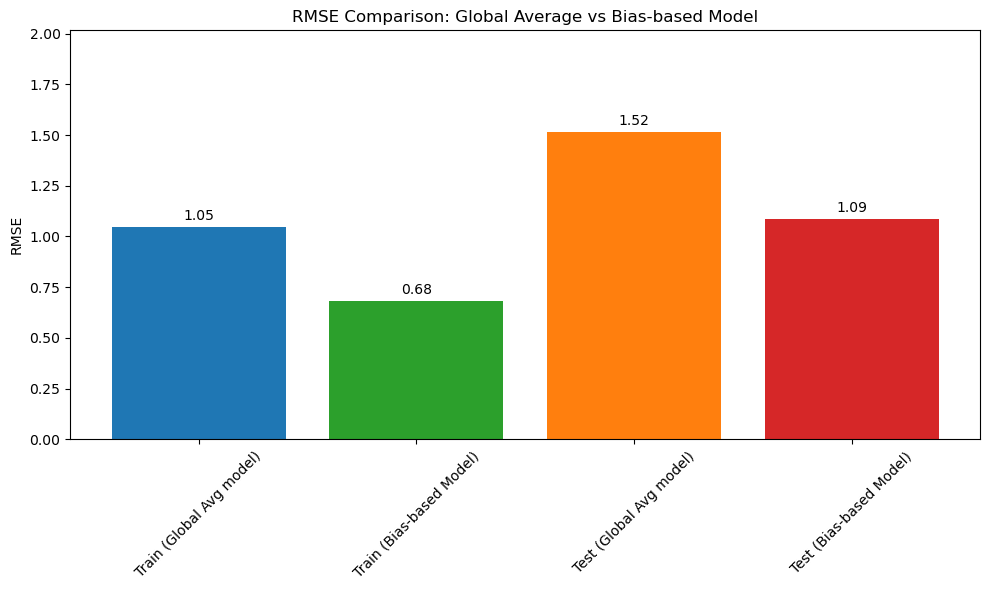

In [95]:
rmse_values = [train_rmse, train_bias_rmse, test_rmse, test_bias_rmse]
labels = ["Train (Global Avg model)", "Train (Bias-based Model)", "Test (Global Avg model)", "Test (Bias-based Model)"]
colors = ['#1f77b4', '#2ca02c', '#ff7f0e', '#d62728']


plt.figure(figsize=(10, 6))
bars = plt.bar(labels, rmse_values, color=colors)
plt.title("RMSE Comparison: Global Average vs Bias-based Model")
plt.ylabel("RMSE")
plt.ylim(0, max(rmse_values) + 0.5)


for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.02, f"{yval:.2f}", ha='center', va='bottom')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()